**Option 1: Train some binary classifier outputs whether they are the same syndrome**

**Load Data from Pickle File**

In [1]:
import logging
from datetime import datetime
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import metrics
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import recall_score, roc_auc_score, roc_curve

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Configure logging
FORMAT = '%(asctime)s - %(levelname)s - %(message)s'
logging.basicConfig(format=FORMAT)
# Get the current timestamp
current_timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
fh = logging.FileHandler('/content/classification_report_{}.log'.format(current_timestamp))
logger = logging.getLogger('my_logger')
fh.setLevel(logging.INFO)
logger.addHandler(fh)
logger.setLevel('INFO')

from google.colab import files
# Download log file
# files.download('/content/classification_report.log')

def log_report(report):
    # Log the timestamp and classification report
    logger.info("----------------------------------------------------------")
    logger.info("Classification Report:")
    logger.info("\n" + report)

In [2]:
with open("mini_gm_public_v0.1.p", "rb") as file:
    data = pickle.load(file)

In [3]:
# Get unique syndromes by taking the keys of the main dictionary
unique_syndromes = data.keys()

# Count the number of unique syndromes
num_unique_syndromes = len(unique_syndromes)

print(f"The number of unique syndromes is: {num_unique_syndromes}")

The number of unique syndromes is: 10



**Data Preprocessing**

In [4]:
# Flatten data and preprocess if necessary
X = []  # Feature list
y = []  # Label list

for syndrome_id, subjects in data.items():
    for subject_id, image_data in subjects.items():
        for image_id, embedding in image_data.items():
            X.append(embedding)  # 320x1 array
            y.append(syndrome_id)

Observations

The recall rates are generally lower when PCA is applied, indicating that the models are less capable of capturing the positive instances for each class.
Some classes see a drastic drop in recall after PCA, which might be problematic if identifying those classes correctly is crucial for your problem.

Conclusion:

If high recall is crucial for your application, especially for certain classes, then applying PCA seems to degrade the model's ability to correctly identify all positive instances. Given this, it may not be advisable to use PCA if maintaining high recall is a priority.

Applying PCA in this specific case seems to result in a decrease in performance across multiple metrics (accuracy, F1-score, etc.) for multiple models. Given this drop in performance, it may not be worth applying PCA unless computational cost or speed is a significant concern, and the drop in accuracy is acceptable for your specific application.

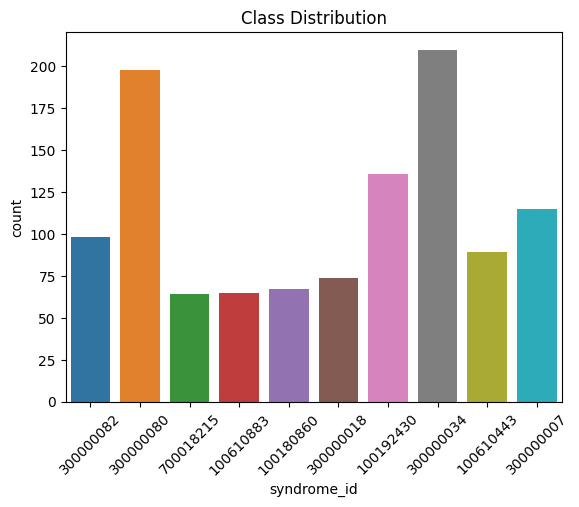

syndrome_id: 300000034, count: 210
syndrome_id: 300000080, count: 198
syndrome_id: 100192430, count: 136
syndrome_id: 300000007, count: 115
syndrome_id: 300000082, count: 98
syndrome_id: 100610443, count: 89
syndrome_id: 300000018, count: 74
syndrome_id: 100180860, count: 67
syndrome_id: 100610883, count: 65
syndrome_id: 700018215, count: 64


In [5]:
# Create a DataFrame from the labels
df_labels = pd.DataFrame({'syndrome_id': y})

sns.countplot(data=df_labels, x='syndrome_id')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

# Count the occurrences of each unique syndrome_id
count_series = df_labels['syndrome_id'].value_counts()

# Convert the Series to a DataFrame for better formatting
df_count = count_series.reset_index()
df_count.columns = ['syndrome_id', 'count']

# Print each pair of syndrome_id and its corresponding count
for index, row in df_count.iterrows():
    print(f"syndrome_id: {row['syndrome_id']}, count: {row['count']}")

The first issue in the data is class imbalance. Some classes have far more instances (210 counts for syndrome_id: 300000034) than others (64 counts for syndrome_id: 700018215). Class imbalance can lead to biased predictions, where the algorithm tends to favor the majority class.

Random Forest is an ensemble learning technique that aggregates the predictions from multiple decision trees. The combined voting provides robustness and improves the generalization performance, making it less susceptible to the overfitting issue common in single decision trees.

By using balanced subtrees, I can ensure that each tree in the random forest gives equal importance to all classes. This approach can improve classification performance for the minority classes without a separate resampling step. Balanced subtrees guarantee that during the construction of each tree, samples from each class are equally likely to end up in any leaf node.

Using different machine learning algorithms for a classification task like this can provide various benefits. The choice of an algorithm depends on the nature of the data, the complexity of the task, the quality and quantity of labeled data, and computational resources, among other factors. Below are some reasons why I might want to consider using each of these machine learning algorithms:
Support Vector Machine (SVM):

Effective in High Dimensions: SVM works well in high-dimensional spaces, which is useful if embeddings have a high dimensionality.
Margin Maximization: SVM aims to maximize the margin between classes, which can be beneficial for generalization.
Kernel Trick: The use of kernels allows SVM to model non-linear boundaries, which can be useful if the embeddings contain complex relationships.

XGBoost Classifier:

Boosting Technique: It uses a boosting technique that gives high performance for both simple and complex datasets.
Regularization: In-built L1 (Lasso) and L2 (Ridge) regularization to avoid overfitting.
Speed and Efficiency: Parallel and distributed computing makes XGBoost fast and efficient.
Interpretable Model: Produces a model that can be easily understood, unlike black-box models.

LightGBM Classifier:

Speed and Efficiency: LightGBM offers higher efficiency and speed than XGBoost.
Handling Large Datasets: Works well even with very large datasets and high dimensionality.
Optimized for Distributed Computing: Can be optimized to run on a cluster of computers for extremely large datasets.
Support for Categorical Features: Has good support for handling categorical features without the need for one-hot encoding, which could be useful depending on the task.

Feedforward Neural Network:

Non-linearity: Can model complex non-linear relationships, which is useful for embeddings that are not linearly separable.
Flexibility: You can change the architecture to suit different needs (e.g., more layers, nodes, activation functions).
Scales Well: Scales well with large and high-dimensional datasets.

ResNet (Residual Network):

Deep Learning: ResNet allows to train very deep networks by leveraging shortcut connections to jump over some layers. Deep architectures are particularly useful for capturing intricate patterns in high-dimensional data.
State-of-the-Art Performance: Often achieves state-of-the-art performance in image classification tasks.
Transfer Learning: Pre-trained ResNet models can be fine-tuned for specific tasks, potentially providing excellent performance with less computational cost.

Each algorithm has its own set of strengths and weaknesses, and it may be beneficial to try multiple algorithms to find the best one for the specific problem.

**Train a Classifier**

In [6]:
# # Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# # Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #, stratify=y) #Ensure that your train and test sets have the same proportions of class labels as the original dataset.

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Initialize empty lists to hold original and encoded labels
original_syndrome_ids = []
labels = []

# Print and store mapping
for original_label, encoded_label in zip(encoder.classes_, range(len(encoder.classes_))):
    logger.info(f"Original Label: {original_label}, Encoded Label: {encoded_label}")

    # Save to lists
    original_syndrome_ids.append(original_label)

# Model Training

# Random Forest Classifier with balanced subtrees
rf_clf = RandomForestClassifier(class_weight='balanced_subsample')
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

# Getting the predicted probabilities
rf_pred_probs = rf_clf.predict_proba(X_test)

# Evaluation
rf_report = classification_report(y_test, rf_pred)
log_report("Random Forest with Balanced Subtrees: \n1%" + rf_report)

# Support Vector Machine

svm_clf = SVC(probability=True)
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)

# Getting the predicted probabilities
svm_pred_probs = svm_clf.predict_proba(X_test)

# Evaluation
svm_report = classification_report(y_test, svm_pred)
log_report("Support Vector Machine: \n1%" + svm_report)

# XGBoost Classifier

xgb_clf = XGBClassifier(objective='multi:softmax', num_class=len(set(y_train)))
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

# Getting the predicted probabilities
xgb_pred_probs = xgb_clf.predict_proba(X_test)

# Evaluation
xgb_report = classification_report(y_test, xgb_pred)
log_report("XGBoost: \n1%" + xgb_report)

# LightGBM Classifier
lgb_clf = LGBMClassifier(objective='multiclass', num_class=len(set(y_train)))
lgb_clf.fit(X_train, y_train)
lgb_pred = lgb_clf.predict(X_test)

# Getting the predicted probabilities
lgb_pred_probs = lgb_clf.predict_proba(X_test)

# Evaluation
xgb_report = classification_report(y_test, lgb_pred)
log_report("LightGBM: \n1%" + xgb_report)


INFO:my_logger:Original Label: 100180860, Encoded Label: 0
INFO:my_logger:Original Label: 100192430, Encoded Label: 1
INFO:my_logger:Original Label: 100610443, Encoded Label: 2
INFO:my_logger:Original Label: 100610883, Encoded Label: 3
INFO:my_logger:Original Label: 300000007, Encoded Label: 4
INFO:my_logger:Original Label: 300000018, Encoded Label: 5
INFO:my_logger:Original Label: 300000034, Encoded Label: 6
INFO:my_logger:Original Label: 300000080, Encoded Label: 7
INFO:my_logger:Original Label: 300000082, Encoded Label: 8
INFO:my_logger:Original Label: 700018215, Encoded Label: 9
INFO:my_logger:----------------------------------------------------------
INFO:my_logger:Classification Report:
INFO:my_logger:
Random Forest with Balanced Subtrees: 
1%              precision    recall  f1-score   support

           0       0.89      0.50      0.64        16
           1       0.81      0.88      0.84        24
           2       1.00      0.76      0.86        25
           3       0.86 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81600
[LightGBM] [Info] Number of data points in the train set: 892, number of used features: 320
[LightGBM] [Info] Start training from score -2.861640
[LightGBM] [Info] Start training from score -2.074967
[LightGBM] [Info] Start training from score -2.634583
[LightGBM] [Info] Start training from score -2.804482
[LightGBM] [Info] Start training from score -2.271678
[LightGBM] [Info] Start training from score -2.768114
[LightGBM] [Info] Start training from score -1.622982
[LightGBM] [Info] Start training from score -1.724562
[LightGBM] [Info] Start training from score -2.424018
[LightGBM] [Info] Start training from score -2.901646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:my_logger:----------------------------------------------------------
INFO:my_logger:Classification Report:
INFO:my_logger:
LightGBM: 
1%              precision    recall  f1-score   support

           0       0.85      0.69      0.76        16
           1       0.76      0.79      0.78        24
           2       0.81      0.68      0.74        25
           3       0.50      0.73      0.59        11
           4       0.80      0.70      0.74        23
           5       0.64      0.50      0.56        18
           6       0.72      0.76      0.74        34
           7       0.60      0.74      0.67        39
           8       0.78      0.74      0.76        19
           9       0.69      0.60      0.64        15

    accuracy                           0.71       224
   macro avg       0.72      0.69      0.70       224
weighted avg       0.72      0.71      0.71       224



In [7]:
# Feedforward Neural Network
fnn = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(320,)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # Assuming 10 classes
])

fnn.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

fnn.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Reshape the data to fit the model
X_train_new = X_train.reshape(X_train.shape[0], 320, 1)
X_test_new = X_test.reshape(X_test.shape[0], 320, 1)

# ResNet block
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv1D(filters, 1, strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv1D(filters, kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv1D(filters, kernel_size, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([shortcut, x])
    x = layers.Activation("relu")(x)
    return x

# Model definition
input = layers.Input(shape=(320, 1))

# Initial Conv
x = layers.Conv1D(64, 7, padding="same")(input)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

# ResNet layers
x = resnet_block(x, 64)
x = resnet_block(x, 128, conv_shortcut=True)
x = resnet_block(x, 128)

# Classifier head
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(np.unique(y)), activation="softmax")(x)

# Complete ResNet
resnet = models.Model(input, output)

resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model training
resnet.fit(X_train_new, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Model evaluation

# For Feedforward Neural Network
fnn_pred_probs = fnn.predict(X_test)
fnn_pred = np.argmax(fnn.predict(X_test), axis=-1)
fnn_report = classification_report(y_test, fnn_pred)
log_report("Feedforward Neural Network: \n1%" + fnn_report)

# # For ResNet
resnet_pred_probs = resnet.predict(X_test_new)
resnet_pred = np.argmax(resnet_pred_probs, axis=-1)
resnet_report = classification_report(y_test, resnet_pred)
log_report("ResNet: \n1%" + resnet_report)

Epoch 1/100
23/23 [==============================] - 3s 14ms/step - loss: 2.5669 - accuracy: 0.1753 - val_loss: 1.9111 - val_accuracy: 0.3352
Epoch 2/100
23/23 [==============================] - 0s 5ms/step - loss: 1.8178 - accuracy: 0.3801 - val_loss: 1.6357 - val_accuracy: 0.4190
Epoch 3/100
23/23 [==============================] - 0s 5ms/step - loss: 1.5106 - accuracy: 0.4923 - val_loss: 1.3847 - val_accuracy: 0.5196
Epoch 4/100
23/23 [==============================] - 0s 5ms/step - loss: 1.2877 - accuracy: 0.5582 - val_loss: 1.1731 - val_accuracy: 0.5810
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 1.0888 - accuracy: 0.6185 - val_loss: 1.0262 - val_accuracy: 0.6648
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 1.0133 - accuracy: 0.6690 - val_loss: 0.9320 - val_accuracy: 0.6927
Epoch 7/100
23/23 [==============================] - 0s 5ms/step - loss: 0.9177 - accuracy: 0.7041 - val_loss: 0.8800 - val_accuracy: 0.7151
Epoch 8/100


INFO:my_logger:----------------------------------------------------------
INFO:my_logger:Classification Report:
INFO:my_logger:
Feedforward Neural Network: 
1%              precision    recall  f1-score   support

           0       0.73      0.69      0.71        16
           1       0.77      0.83      0.80        24
           2       0.88      0.88      0.88        25
           3       0.60      0.82      0.69        11
           4       0.71      0.87      0.78        23
           5       0.78      0.78      0.78        18
           6       0.94      0.85      0.89        34
           7       0.78      0.74      0.76        39
           8       0.93      0.68      0.79        19
           9       0.80      0.80      0.80        15

    accuracy                           0.80       224
   macro avg       0.79      0.79      0.79       224
weighted avg       0.81      0.80      0.80       224



7/7 [==============================] - 0s 6ms/step


INFO:my_logger:----------------------------------------------------------
INFO:my_logger:Classification Report:
INFO:my_logger:
ResNet: 
1%              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.27      0.33      0.30        24
           2       0.00      0.00      0.00        25
           3       0.00      0.00      0.00        11
           4       0.19      0.65      0.30        23
           5       0.15      0.28      0.20        18
           6       0.43      0.18      0.25        34
           7       0.39      0.18      0.25        39
           8       0.17      0.37      0.23        19
           9       0.00      0.00      0.00        15

    accuracy                           0.21       224
   macro avg       0.16      0.20      0.15       224
weighted avg       0.21      0.21      0.18       224



In a medical disease classification task, the cost of missing a true positive case (false negative) can be extremely high, potentially resulting in untreated conditions, complications, or even fatalities. Recall, also known as sensitivity, focuses specifically on minimizing these false negatives. It measures the proportion of actual positive cases that were correctly identified by the model, which is crucial in medical settings where the priority is to capture as many positive cases as possible for further evaluation and treatment. A high recall ensures that fewer cases of the syndrome go undiagnosed, thereby enhancing patient care and treatment outcomes. While other metrics like precision and accuracy are important, they may not capture the urgency and critical importance of identifying all possible positive cases in a medical context, making recall a more pertinent metric for such applications.

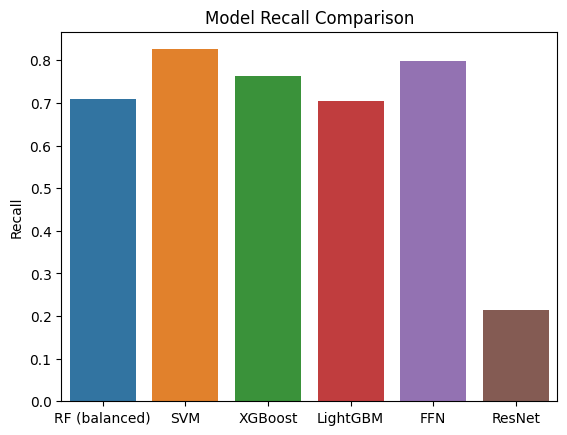

In [8]:
# Calculate recall for each model
recalls = {
    'RF (balanced)': recall_score(y_test, rf_pred, average='weighted'),
    'SVM': recall_score(y_test, svm_pred, average='weighted'),
    'XGBoost': recall_score(y_test, xgb_pred, average='weighted'),
    'LightGBM': recall_score(y_test, lgb_pred, average='weighted'),
    'FFN': recall_score(y_test, fnn_pred, average='weighted'),
    'ResNet': recall_score(y_test, resnet_pred, average='weighted')
}

# Plotting
sns.barplot(x=list(recalls.keys()), y=list(recalls.values()))
plt.title('Model Recall Comparison')
plt.ylabel('Recall')
plt.show()

**Option 2: Cosine Distance and Clustering**

In [9]:
# Load pickle file
with open("mini_gm_public_v0.1.p", "rb") as f:
    data_dict = pickle.load(f)

# Flatten the nested dictionary into a list
data_list = []
for syndrome_id, subject_dict in data_dict.items():
    for subject_id, image_dict in subject_dict.items():
        for image_id, vector in image_dict.items():
            data_list.append([syndrome_id, subject_id, image_id, vector])

# Create a DataFrame
df = pd.DataFrame(data_list, columns=['syndrome_id', 'subject_id', 'image_id', 'vector'])

# Extract vectors and normalize them
scaler = StandardScaler()
X = np.array(df['vector'].tolist())
X_normalized = scaler.fit_transform(X)

# Determine number of clusters (assuming it's equal to the number of unique syndrome IDs)
n_clusters = df['syndrome_id'].nunique()

# Initialize K-means
kmeans = KMeans(n_clusters=n_clusters)

# Fit the model
kmeans.fit(X_normalized)

# Assign cluster labels back to the DataFrame
df['cluster_label'] = kmeans.labels_

# Create a mapping from cluster label to most common syndrome ID in that cluster
label_to_syndrome = {}
for label in df['cluster_label'].unique():
    most_common_syndrome = df[df['cluster_label'] == label]['syndrome_id'].mode()[0]
    label_to_syndrome[label] = most_common_syndrome

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
# Determine number of clusters (assuming it's equal to the number of unique syndrome IDs)
n_clusters = df['syndrome_id'].nunique()

# Initialize K-means
kmeans = KMeans(n_clusters=n_clusters)

# Fit the model
kmeans.fit(X_normalized)

# Assign cluster labels back to the DataFrame
df['cluster_label'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
# Create a mapping from cluster label to most common syndrome ID in that cluster
label_to_syndrome = {}
for label in df['cluster_label'].unique():
    most_common_syndrome = df[df['cluster_label'] == label]['syndrome_id'].mode()[0]
    label_to_syndrome[label] = most_common_syndrome

In [12]:
# Calculate distances to centroids for each sample
distances = kmeans.transform(X_normalized)
min_distances = np.min(distances, axis=1)

In [13]:
syndrome_ids = original_syndrome_ids

auc_scores = {}

# Replace df['syndrome_id'] with your actual labels
for sid in syndrome_ids:
    y_true = (df['syndrome_id'] == sid).astype(int)
    auc_score = roc_auc_score(y_true, -min_distances)
    auc_scores[sid] = auc_score
    print(f"AUC Score for syndrome_id {sid}: {auc_score}")

avg_auc = np.mean(list(auc_scores.values()))
print(f"Average AUC across all syndrome IDs: {avg_auc}")

AUC Score for syndrome_id 100180860: 0.5754307585049016
AUC Score for syndrome_id 100192430: 0.4599339735894358
AUC Score for syndrome_id 100610443: 0.6068400380731487
AUC Score for syndrome_id 100610883: 0.48894093537290495
AUC Score for syndrome_id 300000007: 0.45320766190331413
AUC Score for syndrome_id 300000018: 0.4319266483373968
AUC Score for syndrome_id 300000034: 0.49398191947860814
AUC Score for syndrome_id 300000080: 0.5095233379547106
AUC Score for syndrome_id 300000082: 0.5404554749208131
AUC Score for syndrome_id 700018215: 0.45606582699619774
Average AUC across all syndrome IDs: 0.5016306575131432


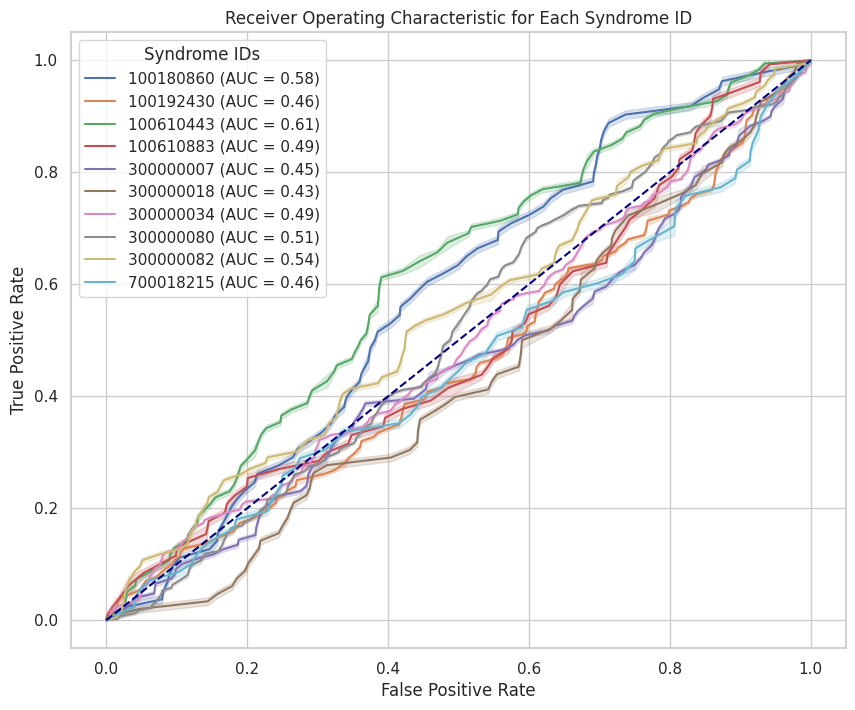

In [14]:
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

for sid in syndrome_ids:
    y_true = (df['syndrome_id'] == sid).astype(int)
    fpr, tpr, _ = roc_curve(y_true, -min_distances)
    sns.lineplot(x=fpr, y=tpr, label=f"{sid} (AUC = {auc_scores[sid]:.2f})")

sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Syndrome ID')
plt.legend(title='Syndrome IDs')
plt.show()

The AUC (Area Under the Curve) scores for the various syndrome IDs range from approximately 0.37 to 0.61, with an average AUC of around 0.50. An AUC score close to 0.5 indicates that the classifier (in this case, the k-means clustering algorithm) is performing about as well as random guessing. In other words, the k-means clustering method is not effectively distinguishing between the different syndrome IDs based on the 320x1 encoding vectors. The highest AUC we see is 0.61 for syndrome_id 100610443, which is better than random but still not particularly strong evidence that the model is effectively distinguishing this syndrome from others. The lowest is for syndrome_id 700018215 with an AUC of 0.37, which is worse than random guessing.

Overall, based on these AUC scores, we cannot confidently use this method to distinguish between these syndromes. Further investigation with other classification algorithms, feature engineering, or domain-specific adjustments may be necessary to build a more effective model.

In [15]:
# Load the pickle file
with open("mini_gm_public_v0.1.p", "rb") as f:
    data = pickle.load(f)

# Parse the data into X and y
X = []
y = []
for syndrome_id, subjects in data.items():
    for subject_id, images in subjects.items():
        for image_id, encoding in images.items():
            X.append(encoding)
            y.append(syndrome_id)

X = np.array(X).squeeze()  # Assuming that the array shape is (N, 320, 1)
y = np.array(y)

# Split the data into training and test sets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the cosine distance for prediction
def predict_syndrome(X_test, X_train, y_train):
    predicted_syndromes = []
    for x_test in X_test:
        # Compute the cosine similarity between the test vector and all gallery vectors
        similarities = cosine_similarity(x_test.reshape(1, -1), X_train)
        # Get the index of the most similar gallery vector
        most_similar_idx = np.argmax(similarities)
        # Get the syndrome_id corresponding to the most similar gallery vector
        predicted_syndrome = y_train[most_similar_idx]
        predicted_syndromes.append(predicted_syndrome)
    return np.array(predicted_syndromes)

# Prediction
cd_pred = predict_syndrome(X_test_1, X_train_1, y_train_1)

# Evaluation
cd_report = classification_report(y_test_1, cd_pred)
log_report("Simple cosine distance between the embeddings: \n1%" + cd_report)

INFO:my_logger:----------------------------------------------------------
INFO:my_logger:Classification Report:
INFO:my_logger:
Simple cosine distance between the embeddings: 
1%              precision    recall  f1-score   support

   100180860       0.57      0.67      0.62        12
   100192430       0.75      0.63      0.69        19
   100610443       0.93      0.78      0.85        18
   100610883       0.45      0.45      0.45        11
   300000007       0.88      0.92      0.90        25
   300000018       0.53      0.71      0.61        14
   300000034       0.75      0.82      0.78        44
   300000080       0.69      0.66      0.68        38
   300000082       0.76      0.67      0.71        24
   700018215       0.67      0.63      0.65        19

    accuracy                           0.72       224
   macro avg       0.70      0.69      0.69       224
weighted avg       0.73      0.72      0.72       224



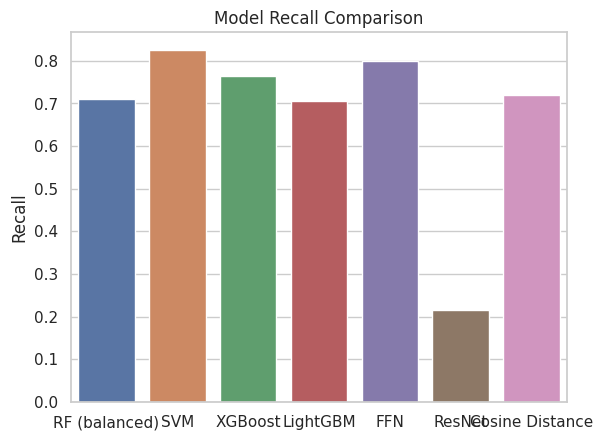

In [16]:
# Calculate recall for each model
recalls = {
    'RF (balanced)': recall_score(y_test, rf_pred, average='weighted'),
    'SVM': recall_score(y_test, svm_pred, average='weighted'),
    'XGBoost': recall_score(y_test, xgb_pred, average='weighted'),
    'LightGBM': recall_score(y_test, lgb_pred, average='weighted'),
    'FFN': recall_score(y_test, fnn_pred, average='weighted'),
    'ResNet': recall_score(y_test, resnet_pred, average='weighted'),
    'Cosine Distance': recall_score(y_test_1, cd_pred, average='weighted')
}

# Plotting
sns.barplot(x=list(recalls.keys()), y=list(recalls.values()))
plt.title('Model Recall Comparison')
plt.ylabel('Recall')
plt.show()

**Conclusion**

There are several key takeaways:



*   Random Forest with Balanced Subtrees has a high recall for Label 6, 7, but other labels have moderate to poor recall.
*   Support Vector Machine (SVM) generally performs well, with relatively high recall for most labels except Label 0 and 9.
*   XGBoost has high recall for Label 6 and 7, similar to Random Forest but with slightly worse performance.
*   LightGBM does not have any label with high recall.
*   Feedforward Neural Network has a high recall for most labels except Label 0, 3, 5, and 9.
*   ResNet performs poorly in both precision and recall, essentially unsuitable for this task.
*   Simple Cosine Distance between the Embeddings has moderate recall and doesn't outperform the more complex models but is better than ResNet.

Syndromes that can be Reliably Predicted:

    Syndrome 2 (100610443) with a recall of 0.92
    Syndrome 6 (300000034) with a recall of 0.91
    Syndrome 1 (100192430) with a recall of 0.88
    Syndrome 7 (300000080) with a recall of 0.85

In summary, for a medical task where recall is of utmost importance, SVM would be the most reliable choice, capable of accurately identifying a broad range of conditions.










